zaczynamy standardowo z **załadowaniem potrzebnych bibliotek**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dane zostały pobrane z platformy **kaggle**: [link](https://www.kaggle.com/datasets/stealthtechnologies/predict-student-performance-dataset)

---

dane zawierają następujące informacje o studentach:
*   **ocena socjoekonomicznego środowiska, w którym dany uczeń dorastał**
(skala oceny wynosi od 0 do 1)
*   **średnia ilość godzin, poświęconych na naukę dziennie**
*   **średnia ilość godzin snu na dobę**
*   **procent frekwencji na zajęciach**
*  **ostateczny wynik ucznia, uzyskany na podstawie kombinacji godzin nauki, godzin snu, wyniku społeczno-ekonomicznego i frekwencji** (ze zbioru wynika, że jest to zmienna docelowa, którą należy przewidzieć)

---

już na tym etapie dane wskazują, że powinna być tu zastosowana **regresja** ---> więc przetestuję różne modele regresyjne, aby sprawdzić który najlepiej przewiduje ostateczny wynik ucznia

---

celem mojego projektu jest wytrenowanie modelu, który odkryje **wzorzec przewidywania wyniku ucznia na podstawie powyższych cech**


---


hipotetycznie, jeśli dostanę dane nowego ucznia, dzięki modelowi, będę znała jego przewidywaną ocenę

**importujemy nasze dane**

In [ ]:
uploaded = files.upload()
data = next(iter(uploaded))
data = pd.read_csv(data)
print(data)

Saving dane uczniow.csv to dane uczniow.csv
      Socioeconomic Score  Study Hours  Sleep Hours  Attendance (%)  Grades
0                 0.95822          3.4          8.2            53.0    47.0
1                 0.85566          3.2          5.9            55.0    35.0
2                 0.68025          3.2          9.3            41.0    32.0
3                 0.25936          3.2          8.2            47.0    34.0
4                 0.60447          3.8         10.0            75.0    33.0
...                   ...          ...          ...             ...     ...
1383              0.44549          5.5          8.0            51.0    41.0
1384              0.52466          4.9          6.5            63.0    37.0
1385              0.88197          3.9          6.2            54.0    36.0
1386              0.47336          3.5          7.3            61.0    34.0
1387              0.58119          3.7          9.7            79.0    35.0

[1388 rows x 5 columns]


**forma tabelaryczna** danych i **wstępne przejrzenie** danych

In [ ]:
print(tabulate(data.head(1000), headers='keys', tablefmt='fancy_grid'))

╒═════╤═══════════════════════╤═══════════════╤═══════════════╤══════════════════╤══════════╕
│     │   Socioeconomic Score │   Study Hours │   Sleep Hours │   Attendance (%) │   Grades │
╞═════╪═══════════════════════╪═══════════════╪═══════════════╪══════════════════╪══════════╡
│   0 │               0.95822 │           3.4 │           8.2 │               53 │       47 │
├─────┼───────────────────────┼───────────────┼───────────────┼──────────────────┼──────────┤
│   1 │               0.85566 │           3.2 │           5.9 │               55 │       35 │
├─────┼───────────────────────┼───────────────┼───────────────┼──────────────────┼──────────┤
│   2 │               0.68025 │           3.2 │           9.3 │               41 │       32 │
├─────┼───────────────────────┼───────────────┼───────────────┼──────────────────┼──────────┤
│   3 │               0.25936 │           3.2 │           8.2 │               47 │       34 │
├─────┼───────────────────────┼───────────────┼─────────────

pierwszym etapem jest **eda**, czyli **eksploracyjna analiza danych**: przejrzę ogólną strukturę danych, ich typy, ewentualne brakujące wartości, rozkłady, wartości odstające



In [ ]:
data.shape

(1388, 5)

dane zawierają **5 kolumn** i **1388 rekordów**

In [ ]:
data.dtypes

,0
Socioeconomic Score,float64
Study Hours,float64
Sleep Hours,float64
Attendance (%),float64
Grades,float64


wszystkie dane są **numeryczne**

In [ ]:
print(data.isnull().any().any())

False


w danych **nie występują żadne brakujące wartości** (**mała dygresja**: jeśli takowe by występowały mogłabym je uzupełnić na podstawie pozostałych danych za pomocą średniej wartości lub mediany ---> czyli nie usuwałabym rekordów z brakującymi wartościami, bo i tak mam ich niewiele, więc hipotetycznie lepszą opcją byłoby uzupełnienie)

patrzymy na **statystyki opisowe**

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Socioeconomic Score,1388.0,0.552274,0.261272,0.10128,0.322118,0.545945,0.78961,0.99982
Study Hours,1388.0,4.560807,1.897581,0.80000,3.475000,3.900000,5.90000,10.00000
Sleep Hours,1388.0,8.047262,1.370700,4.80000,7.000000,8.400000,9.10000,10.00000
Attendance (%),1388.0,58.536023,11.675287,40.00000,49.000000,57.000000,66.00000,100.00000
Grades,1388.0,40.691643,9.467358,32.00000,34.000000,35.000000,47.00000,91.00000


tworzymy **histogramy**, w celu podejrzenia **rozkładów danych**

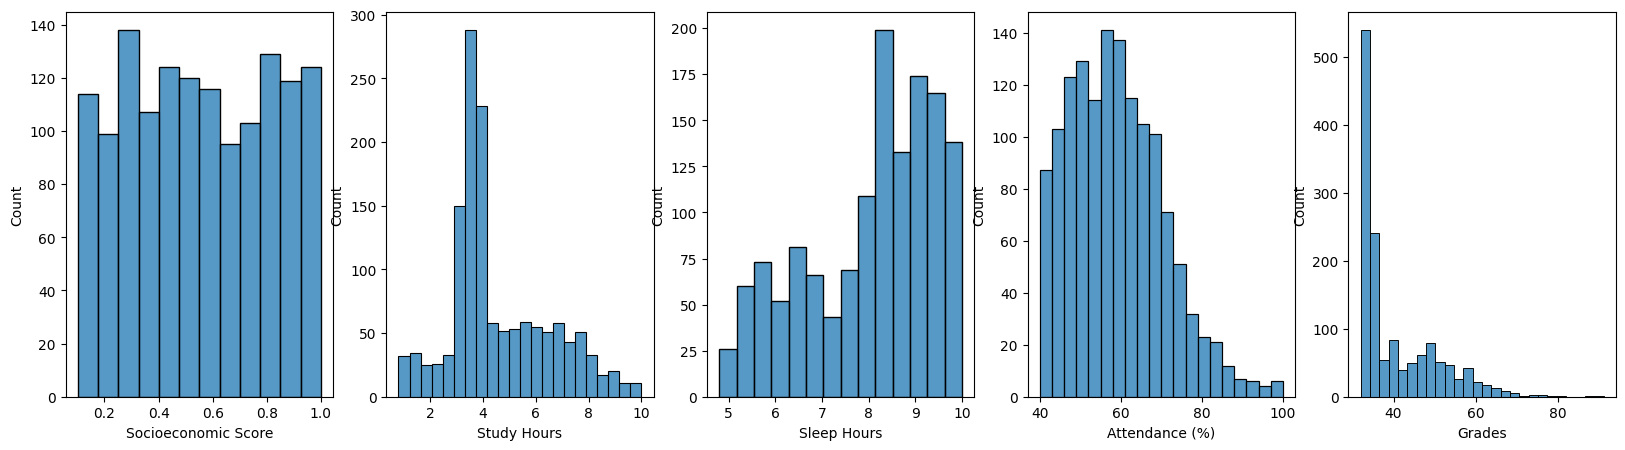

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

sns.histplot(data['Socioeconomic Score'], ax=axs[0]);
sns.histplot(data['Study Hours'], ax=axs[1]);
sns.histplot(data['Sleep Hours'], ax=axs[2]);
sns.histplot(data['Attendance (%)'], ax=axs[3]);
sns.histplot(data['Grades'], ax=axs[4]);

dane w **study hours** i **grades** nie mają rozkładu normalnego i są skośne

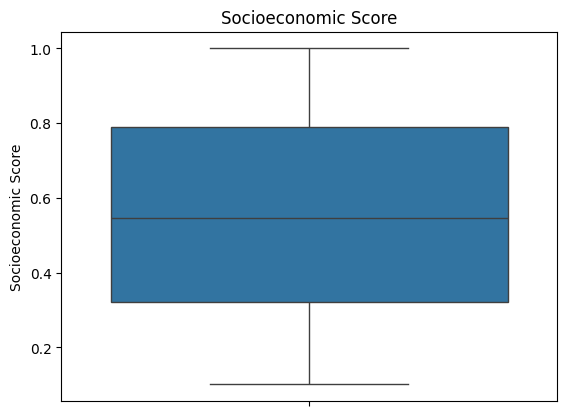

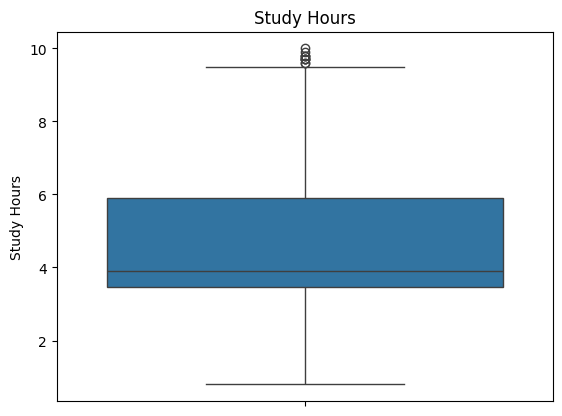

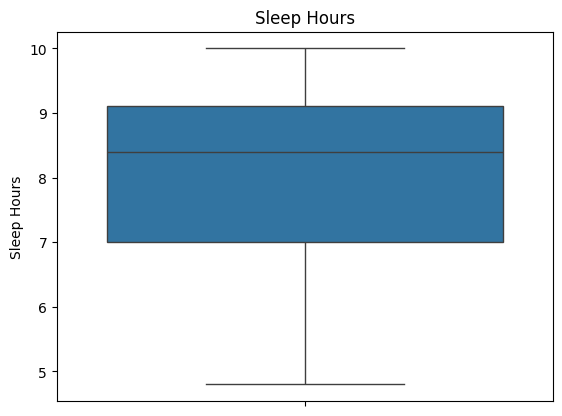

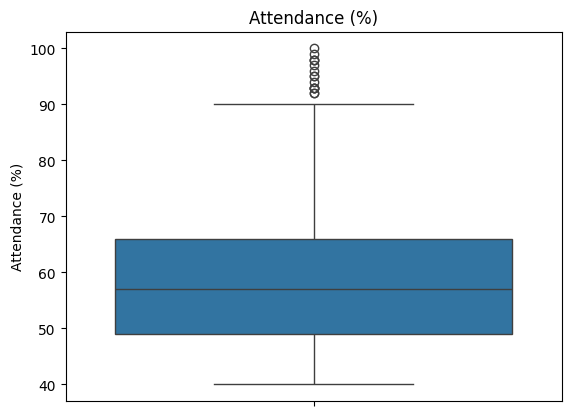

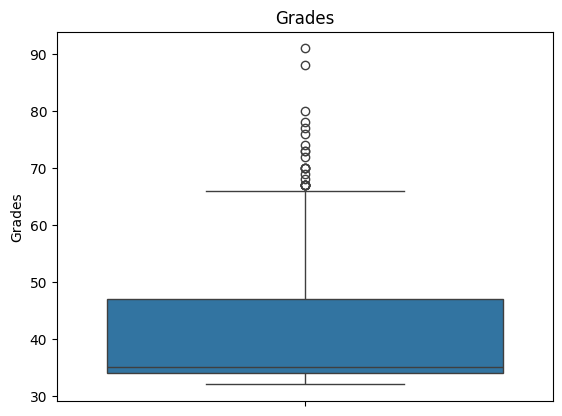

In [ ]:
for col in ['Socioeconomic Score', 'Study Hours', 'Sleep Hours', 'Attendance (%)', 'Grades']:
    sns.boxplot(data[col])
    plt.title(f'{col}')
    plt.show()

po dłuższym zastanowieniu i researchu, stwierdziłam, że **nie usunę wartości odstających**

uzasadnię to tym, że zbiór ma ogólnie mało danych, więc usunięcie tych wartości ogołoci mnie z cennych informacji. drugim powodem jest kontekst danych. ponieważ są to dane o prawdziwych osobach, uczniach, więc mogą wystąpić "wyjątkowe" przypadki, a po analizie tych przypadków, stwierdzam, tak jak poniżej, że takie osoby z takimi danymi mogłyby się trafić

In [ ]:
filtered_data = data[data['Grades'] > 90]
print(tabulate(filtered_data.head(1000), headers='keys', tablefmt='fancy_grid'))

╒═════╤═══════════════════════╤═══════════════╤═══════════════╤══════════════════╤══════════╕
│     │   Socioeconomic Score │   Study Hours │   Sleep Hours │   Attendance (%) │   Grades │
╞═════╪═══════════════════════╪═══════════════╪═══════════════╪══════════════════╪══════════╡
│ 556 │               0.99361 │           9.9 │           6.6 │               57 │       91 │
╘═════╧═══════════════════════╧═══════════════╧═══════════════╧══════════════════╧══════════╛


tutaj wyszukałam sobie osobę z najwyższym wynikiem

ma wysokie zaplecze socjoekonomiczne, długie godziny nauki dziennie za sobą oraz względnie wystarczającą ilość snu na dobę. ma średnią frekwencję na zajęciach, ale z drugiej strony poświęca prawie 10h dziennie na naukę samodzielnie. to wszystko może się przełożyć na tak wysoki wynik tej osoby

In [ ]:
filtered_data = data[data['Attendance (%)'] > 90]
print(tabulate(filtered_data.head(1000), headers='keys', tablefmt='fancy_grid'))

╒══════╤═══════════════════════╤═══════════════╤═══════════════╤══════════════════╤══════════╕
│      │   Socioeconomic Score │   Study Hours │   Sleep Hours │   Attendance (%) │   Grades │
╞══════╪═══════════════════════╪═══════════════╪═══════════════╪══════════════════╪══════════╡
│   74 │               0.74427 │           8.6 │           7.4 │              100 │       58 │
├──────┼───────────────────────┼───────────────┼───────────────┼──────────────────┼──────────┤
│  561 │               0.35115 │           8.1 │           8.2 │               92 │       53 │
├──────┼───────────────────────┼───────────────┼───────────────┼──────────────────┼──────────┤
│  598 │               0.65674 │           8.8 │           5.4 │               98 │       58 │
├──────┼───────────────────────┼───────────────┼───────────────┼──────────────────┼──────────┤
│  786 │               0.83476 │           8.3 │           7.2 │               98 │       59 │
├──────┼───────────────────────┼───────────────┼──

a tutaj z najwyższą frekwencją

podsumowując: po przejrzeniu danych, te wartości odstające **to nie są źle wprowadzone dane**, ale **"wyjątkowe" przypadki wśród studentów**, a pozbywając się ich ryzykuję pozbyciem się, być może, ważnych informacji

wracając do rozkładów - kilka zmiennych nie ma rozkładu normalnego. postanowiłam zastosować na kilku z nich **tranformację logarytmiczną**, która zmniejszy skośność rozkładu, a dodatkowo ograniczy wpływ wartości odstajacych, bez konieczności usuwania ich.

In [ ]:
data['Study Hours'] = np.log(data['Study Hours'] + 1)
data['Grades'] = np.log(data['Grades'] + 1)

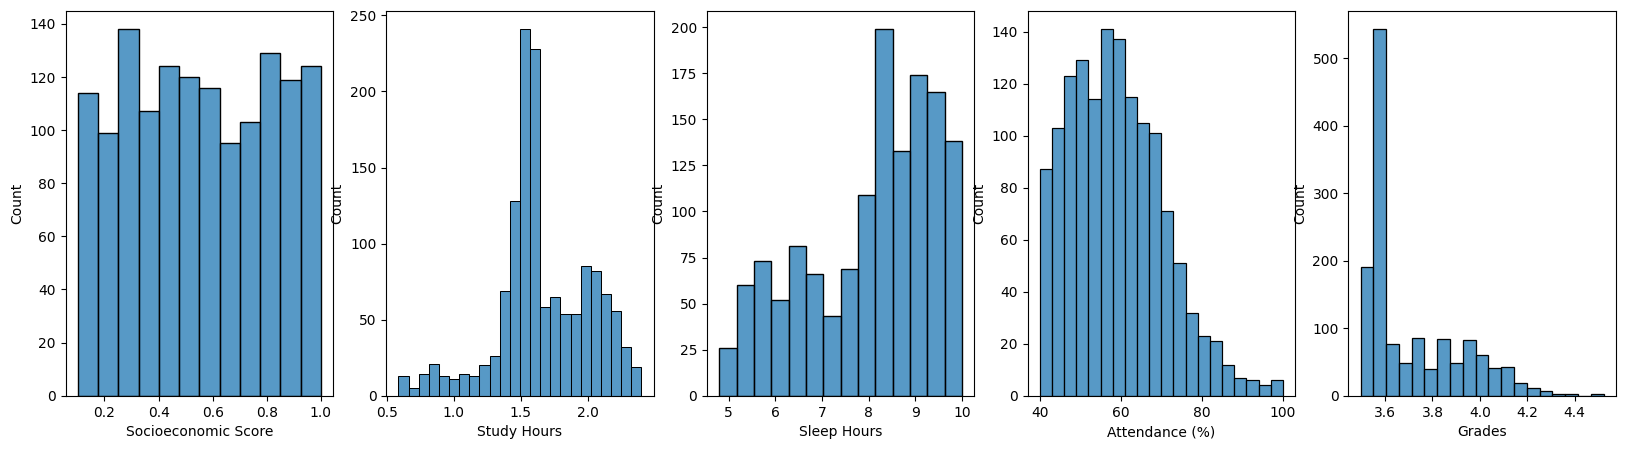

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

sns.histplot(data['Socioeconomic Score'], ax=axs[0]);
sns.histplot(data['Study Hours'], ax=axs[1]);
sns.histplot(data['Sleep Hours'], ax=axs[2]);
sns.histplot(data['Attendance (%)'], ax=axs[3]);
sns.histplot(data['Grades'], ax=axs[4]);

spójrzmy teraz na dane

In [ ]:
print(tabulate(data.head(1000), headers='keys', tablefmt='fancy_grid'))

╒═════╤═══════════════════════╤═══════════════╤═══════════════╤══════════════════╤══════════╕
│     │   Socioeconomic Score │   Study Hours │   Sleep Hours │   Attendance (%) │   Grades │
╞═════╪═══════════════════════╪═══════════════╪═══════════════╪══════════════════╪══════════╡
│   0 │               0.95822 │      1.4816   │           8.2 │               53 │  3.8712  │
├─────┼───────────────────────┼───────────────┼───────────────┼──────────────────┼──────────┤
│   1 │               0.85566 │      1.43508  │           5.9 │               55 │  3.58352 │
├─────┼───────────────────────┼───────────────┼───────────────┼──────────────────┼──────────┤
│   2 │               0.68025 │      1.43508  │           9.3 │               41 │  3.49651 │
├─────┼───────────────────────┼───────────────┼───────────────┼──────────────────┼──────────┤
│   3 │               0.25936 │      1.43508  │           8.2 │               47 │  3.55535 │
├─────┼───────────────────────┼───────────────┼─────────────

w tym momencie decyduję się na ich **standaryzację**, aby wszystkie zmienne były w tej samej skali

In [ ]:
scaler = StandardScaler()

data[['Socioeconomic Score', 'Study Hours', 'Sleep Hours', 'Attendance (%)', 'Grades']] = scaler.fit_transform(data[['Socioeconomic Score', 'Study Hours', 'Sleep Hours', 'Attendance (%)', 'Grades']])

In [ ]:
print(tabulate(data.head(1000), headers='keys', tablefmt='fancy_grid'))

╒═════╤═══════════════════════╤═══════════════╤═══════════════╤══════════════════╤════════════╕
│     │   Socioeconomic Score │   Study Hours │   Sleep Hours │   Attendance (%) │     Grades │
╞═════╪═══════════════════════╪═══════════════╪═══════════════╪══════════════════╪════════════╡
│   0 │            1.55429    │    -0.506204  │     0.111471  │       -0.474337  │  0.800212  │
├─────┼───────────────────────┼───────────────┼───────────────┼──────────────────┼────────────┤
│   1 │            1.16161    │    -0.640212  │    -1.56711   │       -0.302973  │ -0.610547  │
├─────┼───────────────────────┼───────────────┼───────────────┼──────────────────┼────────────┤
│   2 │            0.489994   │    -0.640212  │     0.91427   │       -1.50252   │ -1.03724   │
├─────┼───────────────────────┼───────────────┼───────────────┼──────────────────┼────────────┤
│   3 │           -1.12151    │    -0.640212  │     0.111471  │       -0.988428  │ -0.748694  │
├─────┼───────────────────────┼─────────

okej, w tym momencie kończę przeprowadzanie eksploracyjnej analizy danych

co zrobiłam?
* przejrzałam dane, w celu zapoznania się z nimi i co reprezentują
*   sprawdziłam typy danych ---> zmienne numeryczne
*   sprawdziłam, czy są braki w danych ---> nie ma
* sprawdziłam, czy występują wartości odstające ---> tak, ale uzasadniłam swoją decyzję o nieusuwaniu ich
* sprawdziłam rozkłady zmiennych ---> przeprowadziłam transformację logarytmiczną
* przeprowadziłam standaryzację danych, żeby ujednolicić ich skalę

teraz możemy przejść do kolejnego etapu - **podziału danych**

postanowiłam podzielić dane w sposób standardowy tj.:
*   zbiór **treningowy**, na którym model będzie się uczył - **80%**
*   zbiór **testowy**, na którym oprzemy naszą ocenę modelu - **20%**

!!! z czego zbiór treningowy podzielić proporcją **90/10** na właściwy zbiór treningowy i zbiór **walidacyjny**, który jest kluczowy dla kontrolowania overfittingu


In [ ]:
x = data[['Socioeconomic Score', 'Study Hours', 'Sleep Hours', 'Attendance (%)']]
y = data['Grades']

In [ ]:
x_treningowy_full, x_testowy, y_treningowy_full, y_testowy = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
x_treningowy, x_walidacyjny, y_treningowy, y_walidacyjny = train_test_split(x_treningowy_full, y_treningowy_full, test_size=0.1, random_state=42)

In [ ]:
print(len(x_treningowy))
print(len(x_walidacyjny))
print(len(x_testowy))

999
111
278


okej, wspomnę jeszcze raz, ale oficjalnie o celu tego projektu

celem projektu jest **przewidzenie zmiennej docelowej - oceny ucznia, za pomocą zmiennych niezależnych, czterech cech opisujących uczniów**:
1. oceny socjoekonomicznego "backgroundu" uczniów
2. średniej ilości godzin nauki dziennie
3. średniej ilości godzin snu na dobę
4. procentu frekwencji na zajęciach



koljenym etapem jest **testowanie różnych modeli** oraz **wybranie najlepszeog i najdokładniejszego**

przewidywać będę za pomocą **modelu regresyjnego** - zacznę od **regresji liniowej**, ponieważ jest najprostsza

In [ ]:
regresja_liniowa = LinearRegression()

In [ ]:
regresja_liniowa.fit(x_treningowy, y_treningowy)

LinearRegression()

In [ ]:
y_walid_pred = regresja_liniowa.predict(x_walidacyjny)

jeśli chodzi o miary objaśniające jakość modelu, wybrałam te trzy:
1. **rmse** - o ile średnio model się myli w przewidywaniu wyników ucznia (jest bardziej intuicyjny niż zwykły mse)
2. **mae** - średni błąd bezwzględny, a co bardzo ważne w moim przypadku, odporny na outliery
3. **r2** - pokazuje, jak dobrze model dopasowuje się do danych


In [ ]:
rmse_walid = np.sqrt(mean_squared_error(y_walidacyjny, y_walid_pred))
mae_walid = mean_absolute_error(y_walidacyjny, y_walid_pred)
r2_walid = r2_score(y_walidacyjny, y_walid_pred)

In [ ]:
print(f"rmse: {rmse_walid}")
print(f"mae: {mae_walid}")
print(f"r2: {r2_walid}")

rmse: 0.5486871941617638
mae: 0.4353379814636225
r2: 0.7277038797053508


podsumowanie:
* średni błąd rmse wynosi **0.55** jednostki, więc jest mały
* mae (**0.43** jednostki) wskazuje na niewielki przeciętny błąd przewidywań
* r2 wskazuje że model wyjaśnia **73%** wyników

reasumując, regresja liniowa działa **zadowalająco**, choć **nie jest idealnie**

w zwykłej regresji liniowej nie ma hiperparametrów, które można dostosować... dlatego postanowiłam przetestować bardziej zaawansowany model regresyjny - **drzewo decyzyjne**

In [ ]:
drzewo_decyzyjne = DecisionTreeRegressor(random_state=42)

In [ ]:
drzewo_decyzyjne.fit(x_treningowy, y_treningowy)

DecisionTreeRegressor(random_state=42)

In [ ]:
y_walid_pred2 = drzewo_decyzyjne.predict(x_walidacyjny)

In [ ]:
rmse_walid2 = np.sqrt(mean_squared_error(y_walidacyjny, y_walid_pred2))
mae_walid2 = mean_absolute_error(y_walidacyjny, y_walid_pred2)
r2_walid2 = r2_score(y_walidacyjny, y_walid_pred2)

In [ ]:
print(f"rmse: {rmse_walid2}")
print(f"mae: {mae_walid2}")
print(f"r2: {r2_walid2}")

rmse: 0.21979357850850742
mae: 0.1663488414334915
r2: 0.9563059999578457


 wyniki dla drzewa decyzyjnego są **o wiele lepsze** niż dla regreji liniowej:
*  rmse wyniósł **0.22** jednostki - błąd jest o wiele mniejszy niż w regresji liniowej i wskazuje na precyzję modelu
*  mae wyniosło **0.17 **jednostki i również jest o wiele mniejsze
* r2 wskazakuje, że model wyjaśnia **95%**, co jest świetnym wynikiem, o wiele lepszym niż w regresji liniowej

pezewidywanie na zbiorze walidacyjnym wykazało, że model drzewa decyzyjnego **świetnie** poradził sobie z danymi... a zatem przechodzę do przetestowania go na właściwym zbiorze testowym


In [ ]:
y_test_pred2 = drzewo_decyzyjne.predict(x_testowy)

In [ ]:
rmse_test2 = np.sqrt(mean_squared_error(y_testowy, y_test_pred2))
mae_test2 = mean_absolute_error(y_testowy, y_test_pred2)
r2_test2 = r2_score(y_testowy, y_test_pred2)

In [ ]:
print(f"rmse: {rmse_test2}")
print(f"mae: {mae_test2}")
print(f"r2: {r2_test2}")

rmse: 0.1920648924798959
mae: 0.14468908225753935
r2: 0.9574479068358248


po przeprowadzeniu predykcji na zbiorze testowym, mogę stwierdzić, że różnice między miarami są niewielkie, co wskazuje na to, że model dobrze generalizuje i co najważniejsze, nie jest **przetrenowany**

na tym etapie mogłabym pozostawić model taki jaki jest, bo dobrze przewiduje wyniki uczniów, ale postanowiłam jeszcze **dostosować hiperparametry**, żeby sprawdzić, czy może być on jeszcze lepszy

w tym celu zastosuję **gridsearchcv**, który dobierze najlepsze kombinacje hiperparametrów

In [ ]:
parametry = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]}

wybrałam **hiperparametry**: **max_depth**, **mix_samples_split**, **min_samples_leaf** oraz **standardowe dla nich wartości**

In [ ]:
drzewo_decyzyjne2 = DecisionTreeRegressor(random_state=42)

In [ ]:
grid_search = GridSearchCV(
    estimator=drzewo_decyzyjne2,
    param_grid=parametry,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_search.fit(x_treningowy, y_treningowy)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
print(f"najlepsze hiperparametry: {grid_search.best_params_}")

najlepsze hiperparametry: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [ ]:
najlepsze_drzewo_decyzyjne2 = grid_search.best_estimator_

In [ ]:
y_walid_pred3 = najlepsze_drzewo_decyzyjne2.predict(x_walidacyjny)

In [ ]:
rmse_walid3 = np.sqrt(mean_squared_error(y_walidacyjny, y_walid_pred3))
mae_walid3 = mean_absolute_error(y_walidacyjny, y_walid_pred3)
r2_walid3 = r2_score(y_walidacyjny, y_walid_pred3)

In [ ]:
print(f"rmse: {rmse_walid3}")
print(f"mae: {mae_walid3}")
print(f"r2: {r2_walid3}")

rmse: 0.1943948990385238
mae: 0.14334413777903962
r2: 0.9658208282484


In [ ]:
y_test_pred3 = najlepsze_drzewo_decyzyjne2.predict(x_testowy)

In [ ]:
rmse_test3 = np.sqrt(mean_squared_error(y_testowy, y_test_pred3))
mae_test3 = mean_absolute_error(y_testowy, y_test_pred3)
r2_test3 = r2_score(y_testowy, y_test_pred3)

In [ ]:
print(f"rmse: {rmse_test3}")
print(f"mae: {mae_test3}")
print(f"r2: {r2_test3}")

rmse: 0.16481640553946983
mae: 0.12186427792697685
r2: 0.9686652791499628


po przeprowadzeniu doboru najlepszych hiperparametrów do modelu drzewa decyzyjnego za pomocą gridsearchcv:
* rmse wyniosło **0.16** jednostki (przed **0.19**) - błąd modelu się zmniejszył o 0.03 jednostki - nadal pozostał mały!
* mae wyniósł **0.12** jednostki (przed **0.14**) - zmniejszył się o 0.02 jednostki - również niski wynik!
* r2 wyniosło **0.97** jednostki (przed **0.96**) - wzrosło o 0.01 jednostki - jest to bardzo wysoka wartość!!

dobranie najlepszych hiperparametrów pozwoliło na niewielką poprawę modelu - wartości zmieniły się nieznacznie, ale takie działanie zawsze jest na plus, by poprawić dokładność modelu

# **podsumowanie:**
projekt polegał na przeprowadzeniu procesu analizy i modelowaniu danych dotyczących wyników uczniów w celu stworzenia modelu przewidującego ich oceny na podstawie wybranych cech

przeprowadzone etapy projektu:
1. **eksploracyjna analiza danych (eda)**:
  * sprawdziłam strukturę danych, typy zmiennych i brakujące wartości (których nie było)
  * przeanalizowałam rozkłady zmiennych, identyfikując zmienne skośne i wartości odstające
  * zastosowałam transformację logarytmiczną w celu zmniejszenia skośności i standaryzację dla ujednolicenia skali zmiennych
  * podjęłam decyzję o nieusuwaniu wartości odstających, uzasadniając ich ważną i nieprzypadkową obecność w kontekście danych.
2. **podział danych**:
  * dane podzieliłam na zbiór treningowy (80%) i testowy (20%).
  * w ramach zbioru treningowego wydzieliłam zbiór walidacyjny (10%), aby uniknąć przeuczenia modelu
3. **budowa i ocena modeli**:
  * zaczęłam od przetestowania regresji liniowej, która uznawana jest za najprostszy model regresyjny
  * następnie zastosowałam drzewo decyzyjne, które znacznie poprawiło dokładność przewidywań
  * wybrałam miary rmse, mae i r2, aby ocenić jakość modeli
  * pomimo satysfakcjonujących wyników miar, przeprowadziłam optymalizację hiperparametrów drzewa decyzyjnego za pomocą gridsearchcv w celu zwiększenia dokładności modelu

**ostatecznie wybrany model**:
**drzewo decyzyjne z dostrojonymi hiperparametrami uzyskało najlepsze wyniki** - model nie jest przetrenowany, dobrze generalizuje na zbiorze testowym

**efekt**:
finalny model może **skutecznie przewidywać** wyniki uczniów na podstawie ich cech:)







